### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 1

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [8]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [9]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[i]) / (i + 1) for i in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
    return np.mean(cumulative_averages, axis=0)

In [10]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [11]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [118]:
def plot_cumulative_subplots(accuracy_arrays, subtitles, plot_filename=""):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Relearning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [1]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

# ER

## Buffer 500

### Accuracy Without Drift

74.9625

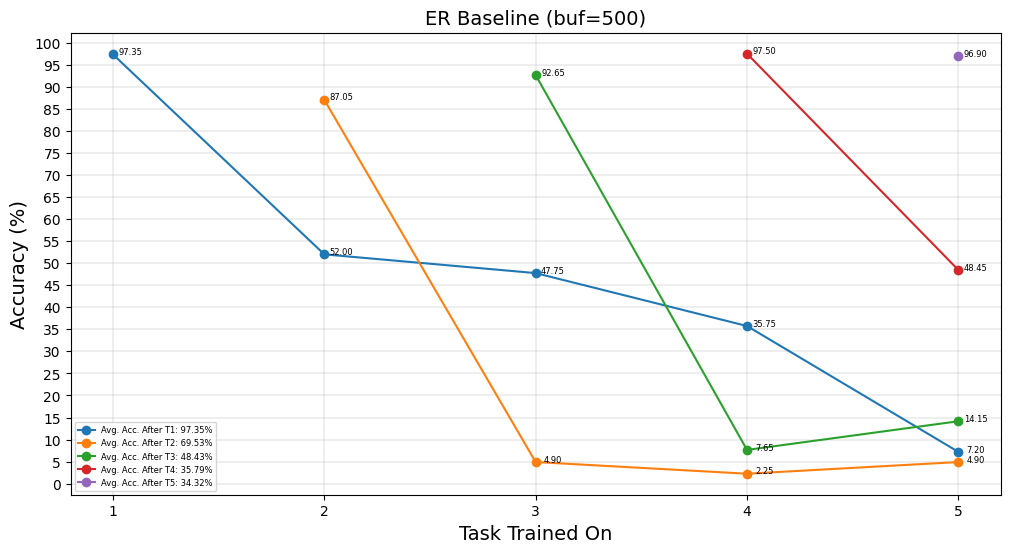

In [48]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-05-28-50-seq-cifar10-er-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 33.82, 33.86, 34.32, 34.74, 35.13
# 34.374 ± 0.5058695484015628
plot_results(
    er_500_accuracy_array_without_drift,
    title="ER Baseline (buf=500)",
)
average_forgetting(er_500_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

77.0625

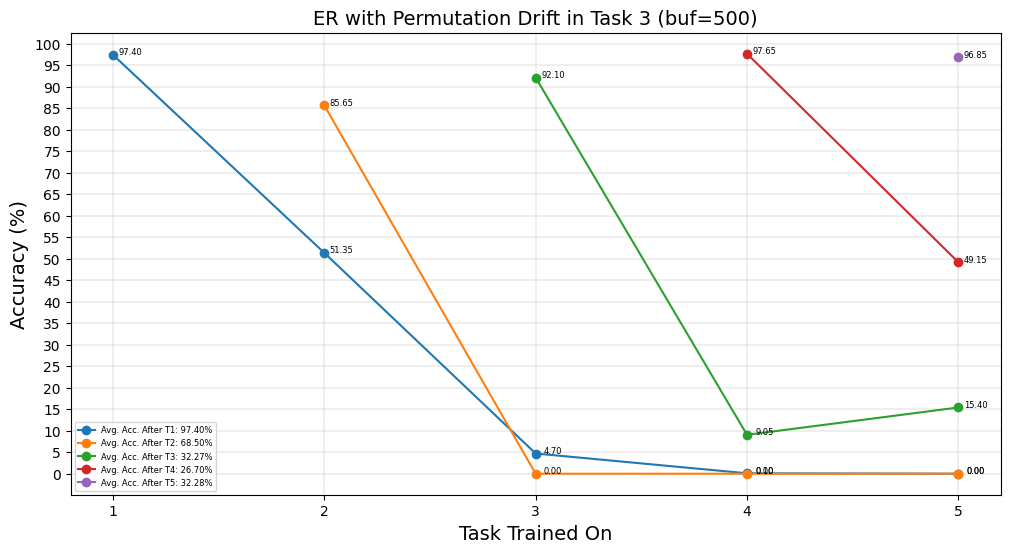

In [47]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-18-25-23-02-01-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-0.json"
)
# 31.76, 31.96, 32.28, 32.61, 33.21
# 32.364000000000004 ± 0.5121171740920233
plot_results(
    er_500_accuracy_array_with_drift,
    title="ER with Permutation Drift in Task 3 (buf=500)",
)
average_forgetting(er_500_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [43]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-01-28-12-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 55.94, 56.16, 56.35, 56.95, 57.22
# # 56.524 ± 0.48367757855828

3 files found
1: ./reimplementation-logs/02-19-25-01-33-47-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-00-53-43-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-14-49-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 56.0
Avg Forgetting: 47.074999999999996


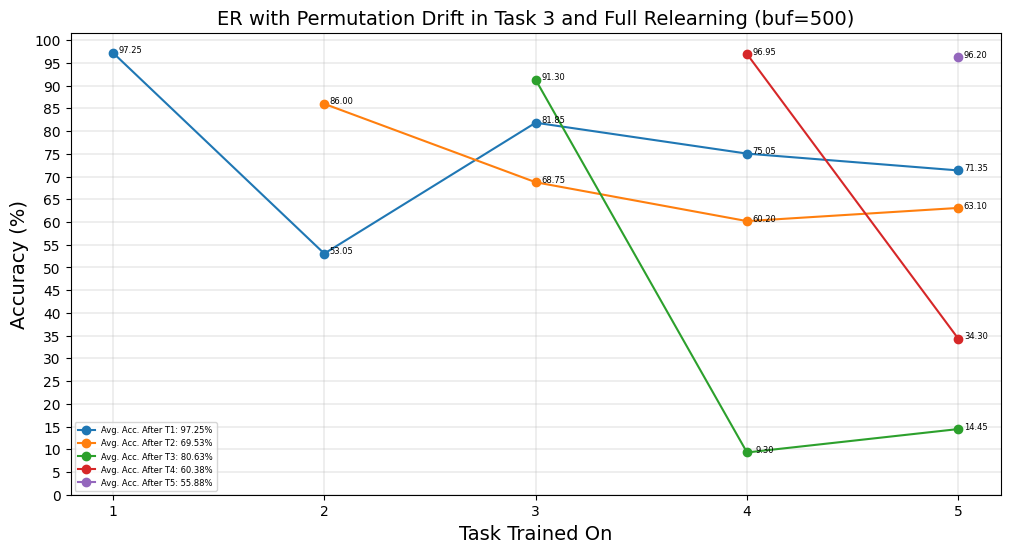

In [44]:
er_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-01-33-47-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
# 55.22, 55.88, 56.90
plot_results(
    er_500_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Task 3 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [37]:
## before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-19-25-03-00-55-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 49.08, 50.00, 50.21, 50.72, 51.84
# # 50.37 ± 0.9066421565314524

3 files found
1: ./reimplementation-logs/02-19-25-02-31-31-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-02-58-33-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-02-02-32-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 51.88333333333333
Avg Forgetting: 52.050000000000004


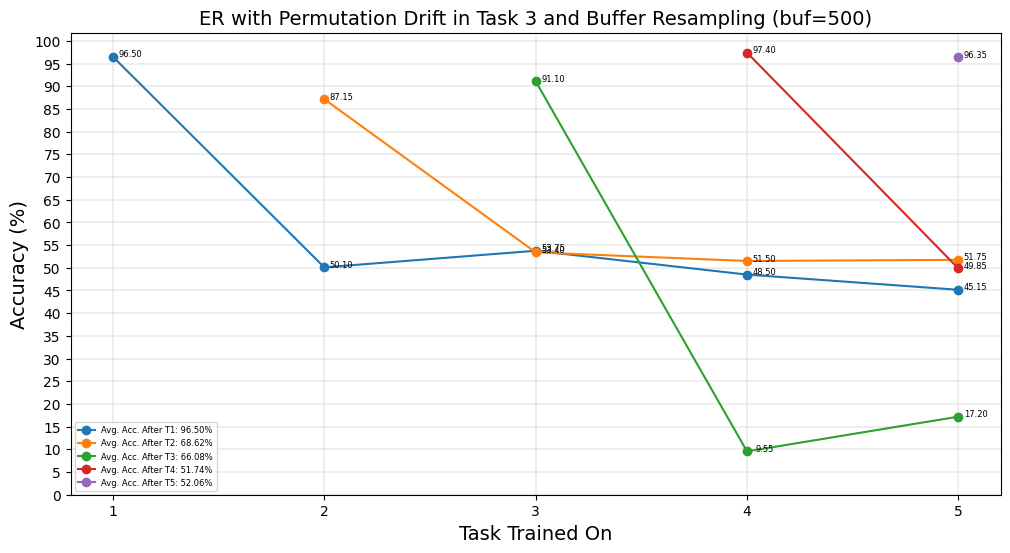

In [ ]:
er_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-02-02-32-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
# 51.18, 52.06, 52.41
plot_results(
    er_500_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

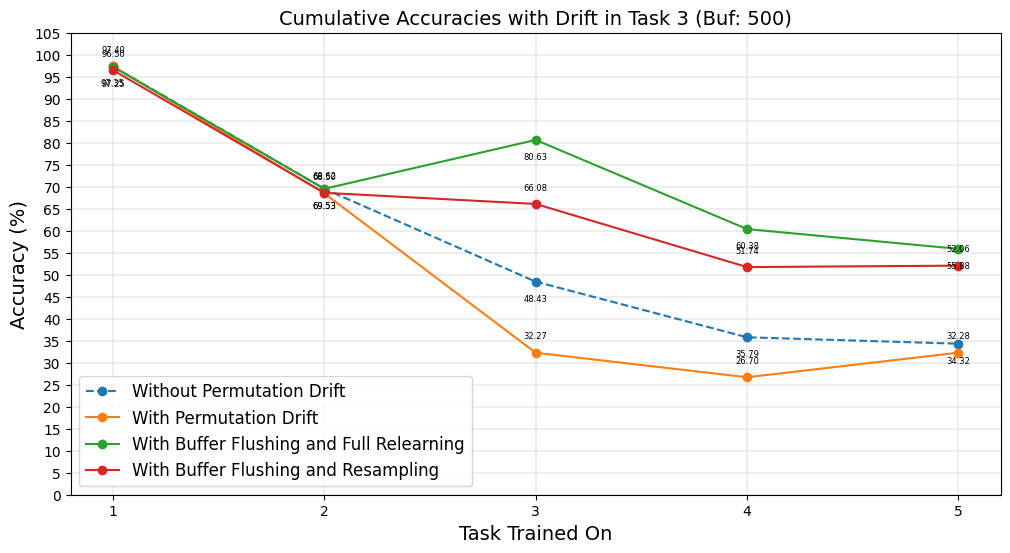

In [49]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

33.25

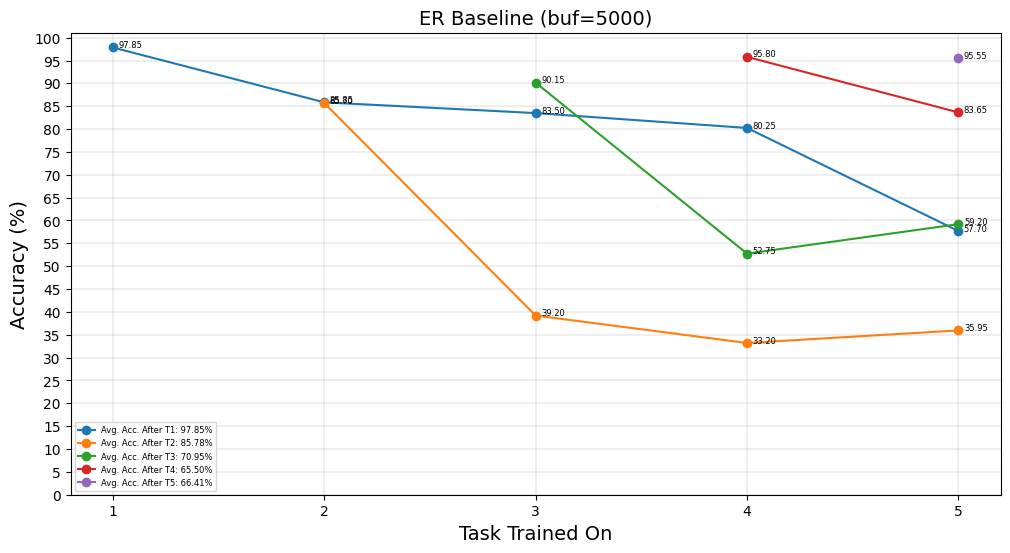

In [14]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-07-25-03-16-59-seq-cifar10-er-buf-5000-no-drift.json"
)
# 65.46, 65.59, 66.41, 66.56, 66.81
# 66.166 ± 0.5403184246349569
plot_results(
    er_5000_accuracy_array_without_drift,
    title="ER Baseline (buf=5000)",
)
average_forgetting(er_5000_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

56.3625

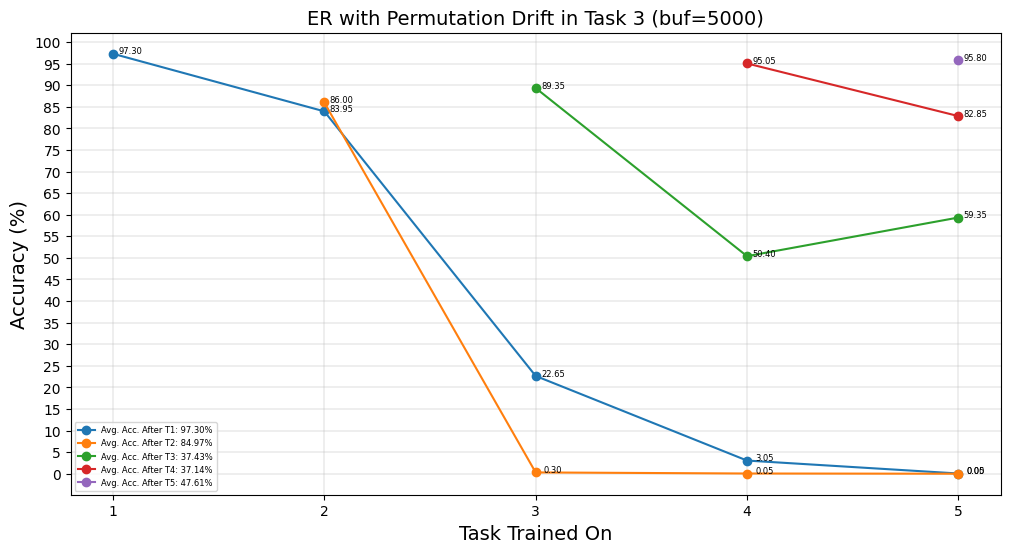

In [15]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-07-25-07-56-20-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 47.27, 47.33, 47.61, 47.77, 47.82
# 47.559999999999995 ± 0.22414281161795058
plot_results(
    er_5000_accuracy_array_with_drift,
    title="ER with Permutation Drift in Task 3 (buf=5000)",
)
average_forgetting(er_5000_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [ ]:
## before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-07-25-09-28-31-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 74.5, 74.6, 75.15, 75.7, 75.81
# # 75.152 ± 0.5409399227271015

3 files found
1: ./reimplementation-logs/02-19-25-00-16-17-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-01-32-14-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-51-54-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 75.27
Avg Forgetting: 21.924999999999997


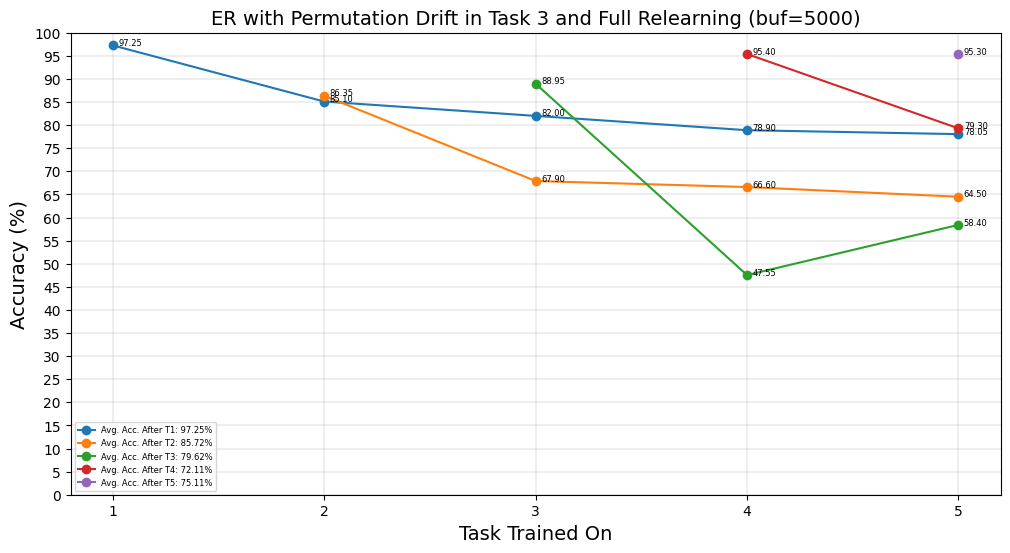

In [ ]:
er_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-00-51-54-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
# 74.87, 75.11, 75.83
plot_results(
    er_5000_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [ ]:
## before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-07-25-10-19-11-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 74.19, 74.29, 74.33, 74.69, 75.01
# # 74.502 ± 0.3050508154390031

3 files found
1: ./reimplementation-logs/02-19-25-02-28-34-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-02-00-44-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-02-57-39-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 73.92333333333333
Avg Forgetting: 24.200000000000003


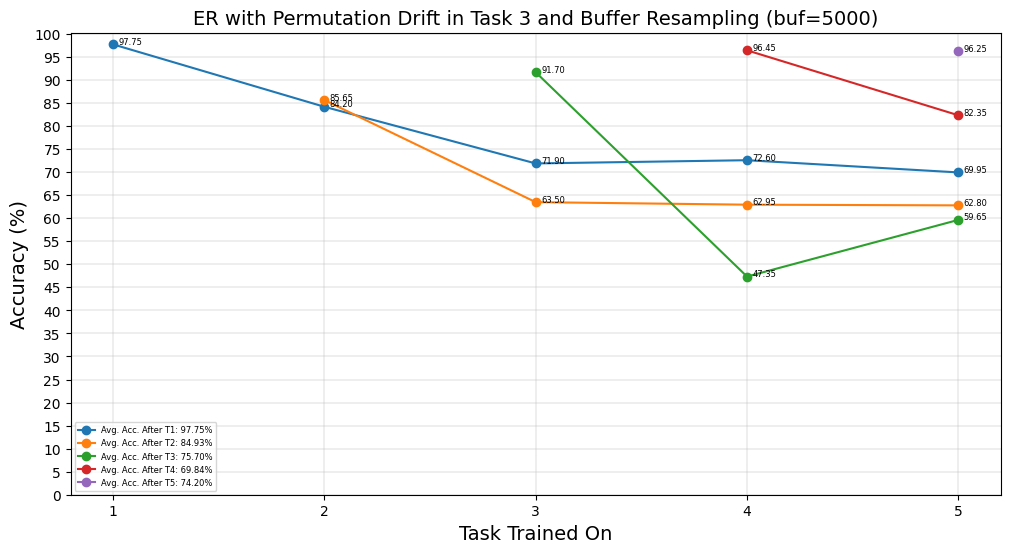

In [25]:
er_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-02-57-39-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
# 73.33, 74.15, 74.20, 74.24, 74.43
plot_results(
    er_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

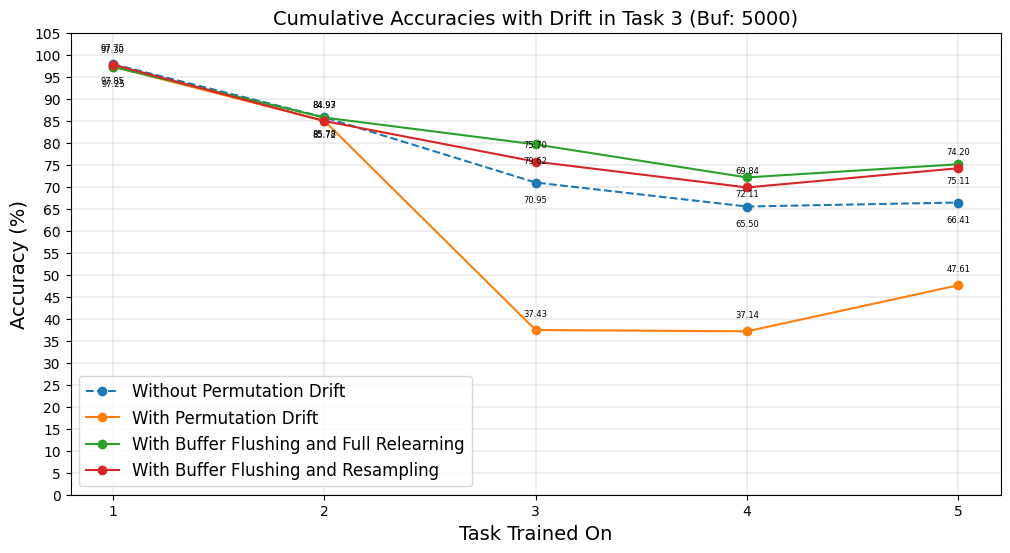

In [32]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

29.262499999999996

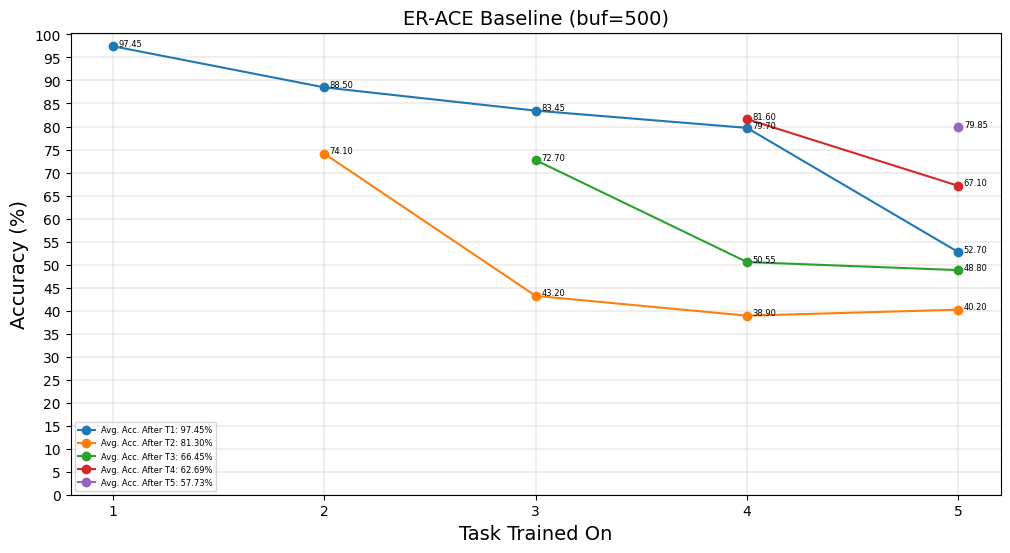

In [50]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-05-28-50-seq-cifar10-er_ace-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 55.74, 56.39, 57.73, 57.98, 58.76
# 57.31999999999999 ± 1.0989631476987733
plot_results(
    er_ace_500_accuracy_array_without_drift,
    title="ER-ACE Baseline (buf=500)",
)
average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

52.400000000000006

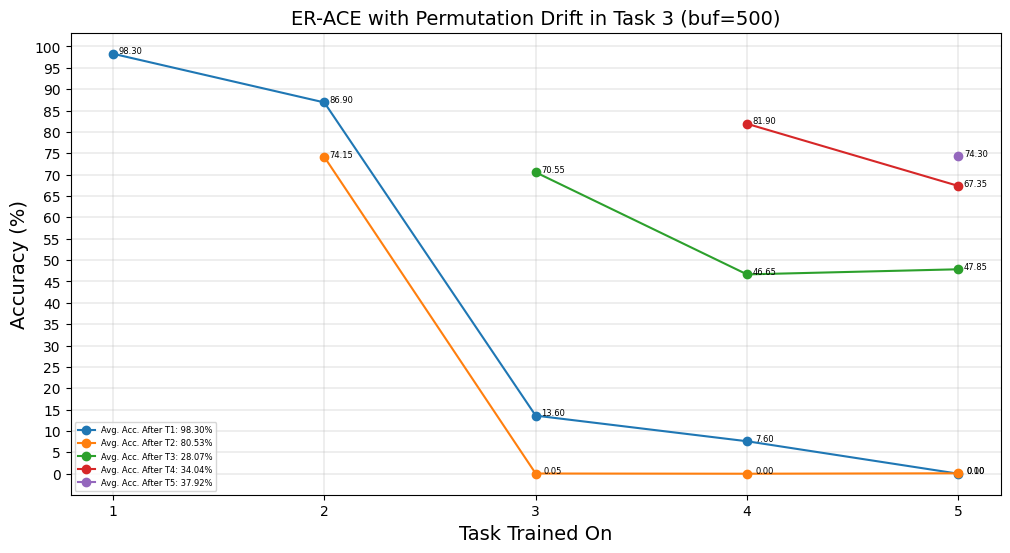

In [51]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-18-25-22-56-03-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-0.json"
)
# 36.25, 37.02, 37.92, 38.44, 38.77
# 37.68 ± 0.927771523598348
plot_results(
    er_ace_500_accuracy_array_with_drift,
    title="ER-ACE with Permutation Drift in Task 3 (buf=500)",
)
average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [ ]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-01-21-29-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 62.72, 63.26, 63.47, 64.02
# # 63.36749999999999 ± 0.4655843103026552

3 files found
1: ./reimplementation-logs/02-19-25-02-48-55-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-00-40-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-01-42-19-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 60.49666666666667
Avg Forgetting: 28.27499999999999


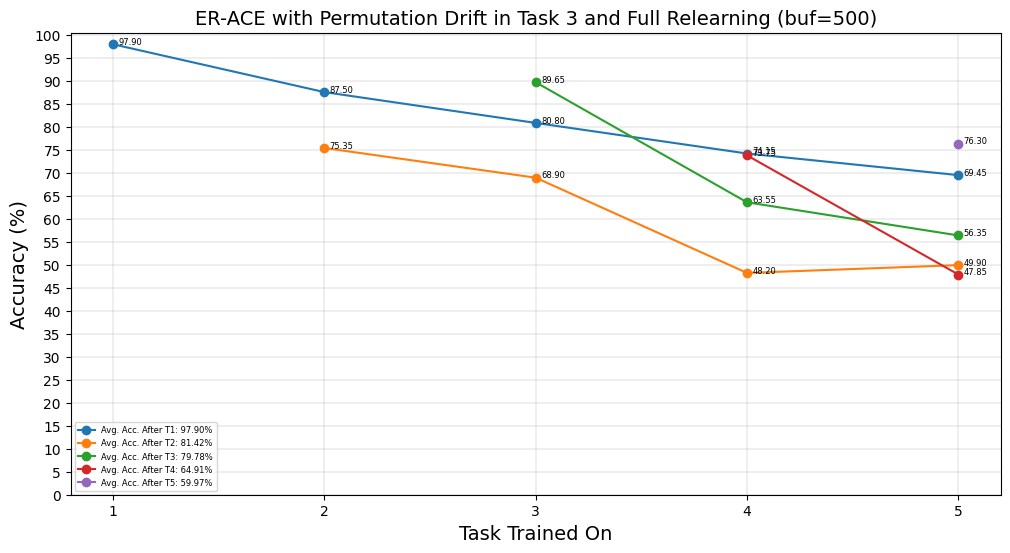

In [61]:
er_ace_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-00-40-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
# 59.95, 59.97, 61.57
plot_results(
    er_ace_500_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Task 3 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [66]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-19-25-18-34-18-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 59.62, 59.76, 60.38, 61.15, 61.57
# # 60.496 ± 0.762065613972971

3 files found
1: ./reimplementation-logs/02-19-25-03-36-20-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-05-15-07-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-04-24-38-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 60.01666666666667
Avg Forgetting: 32.3375


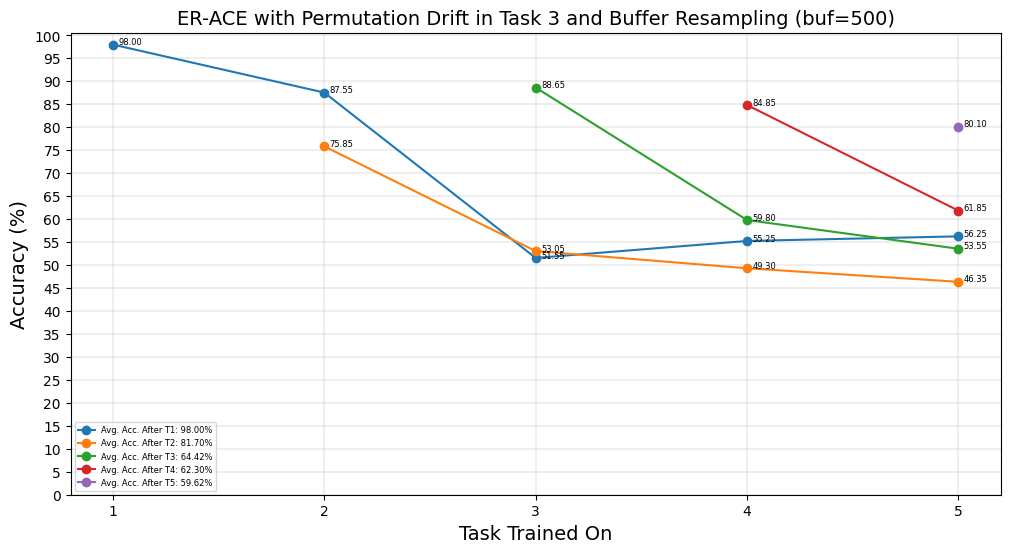

In [70]:
er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-03-36-20-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
# 59.47, 59.62, 60.96
plot_results(
    er_ace_500_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

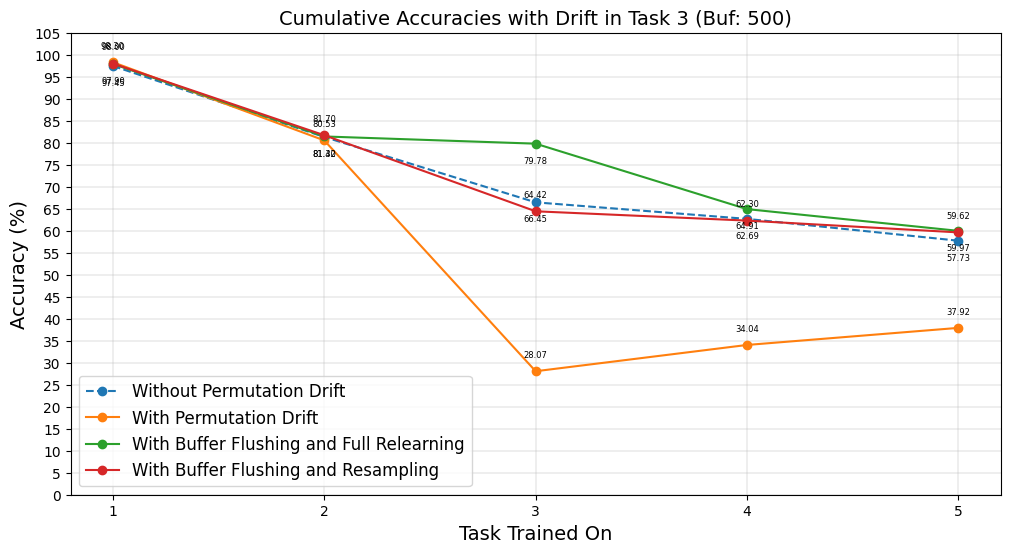

In [71]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

13.8625

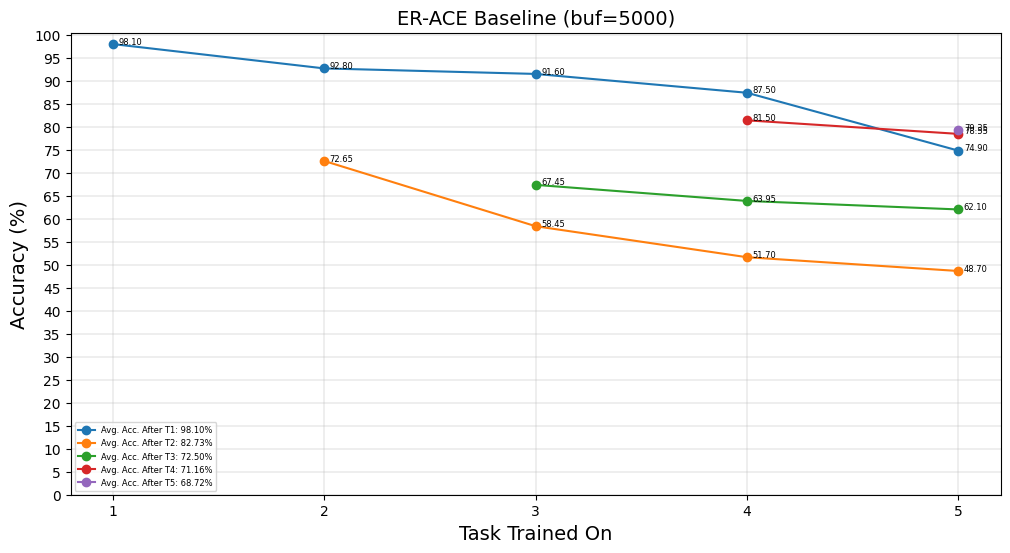

In [72]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-14-25-23-00-53-seq-cifar10-er_ace-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 68.05, 68.51, 68.72, 68.74, 69.78
# 68.75999999999999 ± 0.5672741841473141
plot_results(
    er_ace_5000_accuracy_array_without_drift,
    title="ER-ACE Baseline (buf=5000)",
)
average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

46.050000000000004

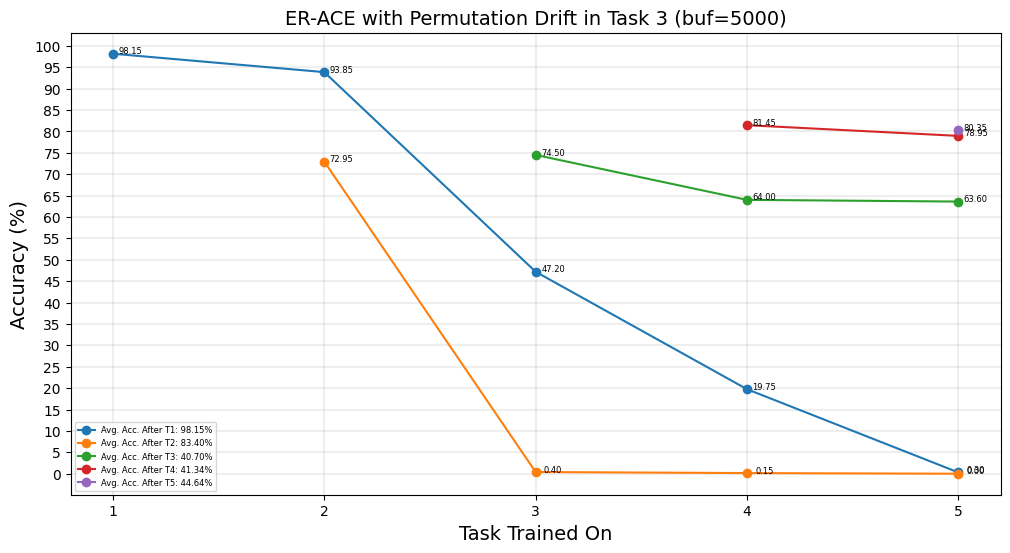

In [73]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-14-25-23-01-52-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 44.06, 44.22, 44.64, 44.90, 45.27
# 44.61800000000001 ± 0.4415608678313787
plot_results(
    er_ace_5000_accuracy_array_with_drift,
    title="ER-ACE with Permutation Drift in Task 3 (buf=5000)",
)
average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [76]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-14-25-23-33-58-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 73.64, 73.84, 73.92, 74.19, 74.39
# # 73.99600000000001 ± 0.26446927987953456

3 files found
1: ./reimplementation-logs/02-19-25-01-47-26-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-02-51-35-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-44-27-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 71.07333333333334
Avg Forgetting: 15.362500000000006


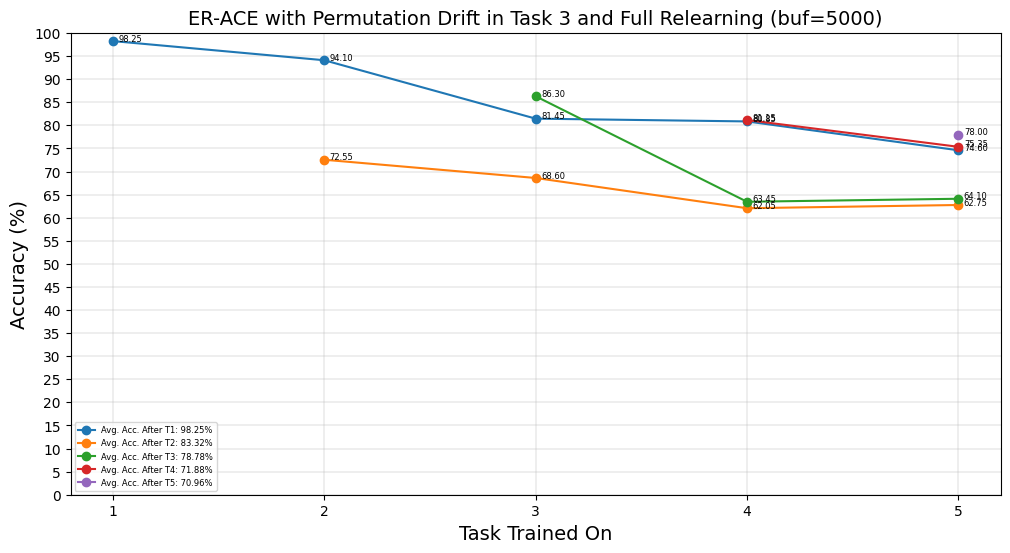

In [79]:
er_ace_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-01-47-26-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
# 70.59, 70.96, 71.67
plot_results(
    er_ace_5000_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [84]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-14-25-23-10-23-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 72.52, 73.1, 73.23, 73.26, 73.28
# # 73.078 ± 0.28596503282744473

3 files found
1: ./reimplementation-logs/02-19-25-05-20-00-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-03-39-50-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-04-29-39-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 73.58
Avg Forgetting: 16.300000000000004


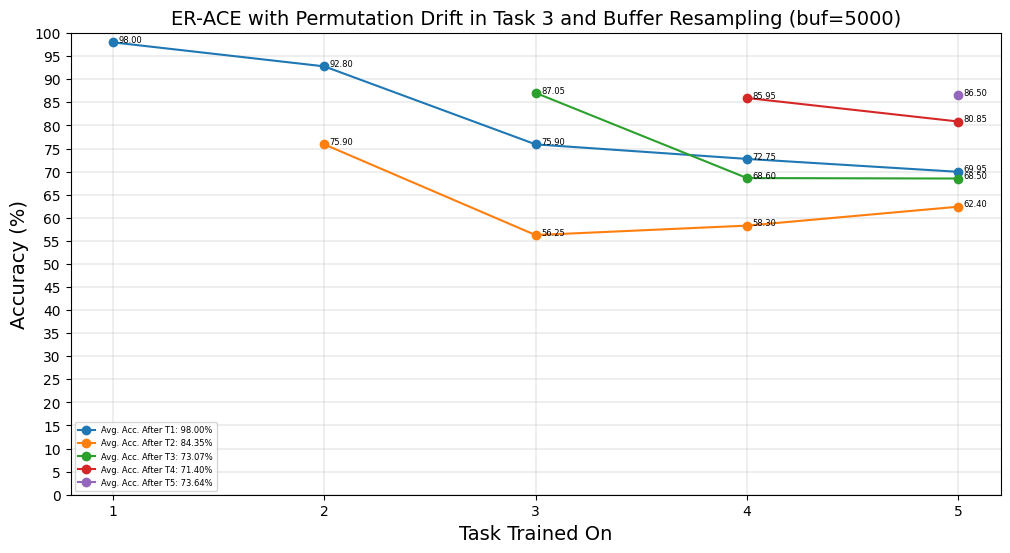

In [85]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-04-29-39-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
# 73.16, 73.64, 73.94
plot_results(
    er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

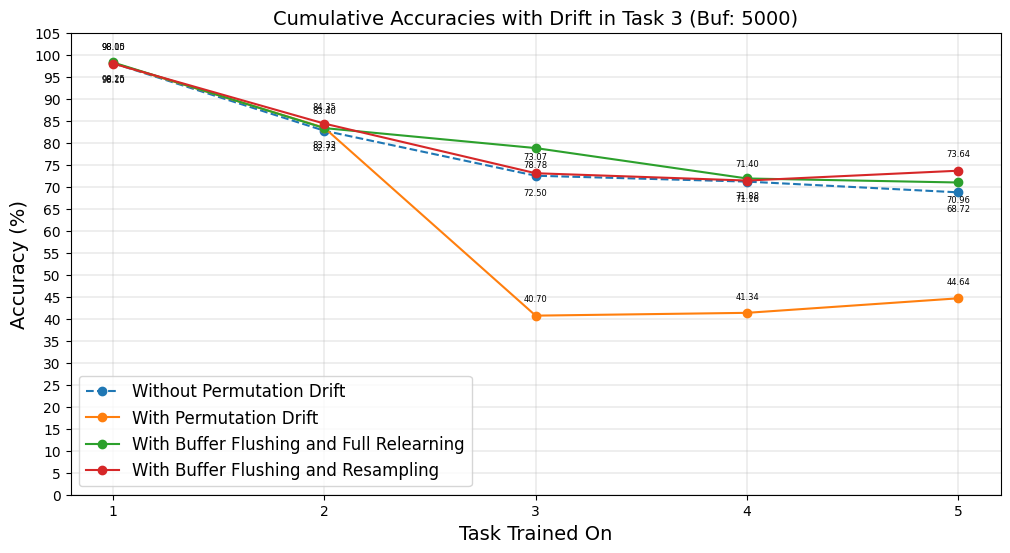

In [86]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

63.55

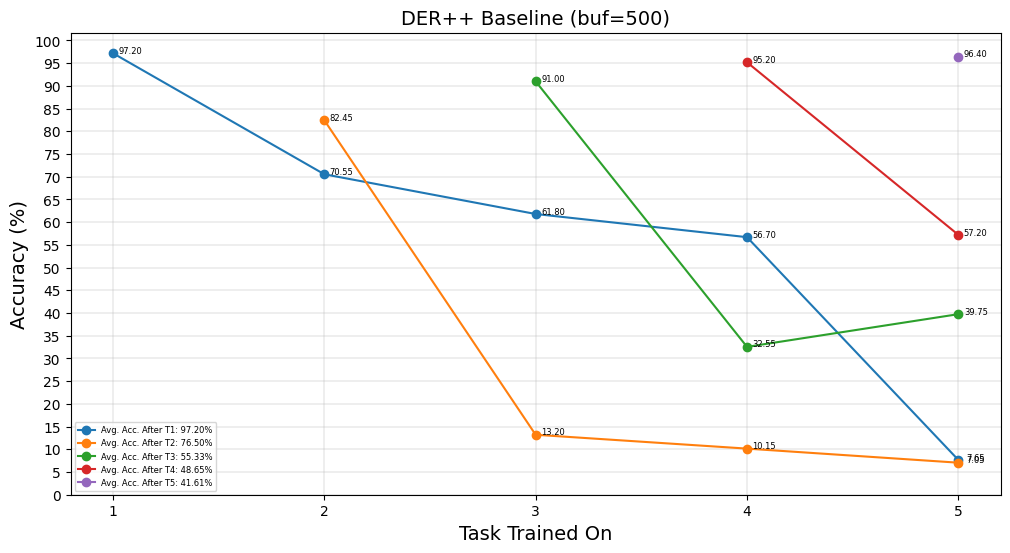

In [87]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-19-53-51-seq-cifar10-derpp-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 40.35, 41.20, 41.61, 41.63, 42.23
# 41.404 ± 0.6210185182424098
plot_results(
    derpp_500_accuracy_array_without_drift,
    title="DER++ Baseline (buf=500)",
)
average_forgetting(derpp_500_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

68.1375

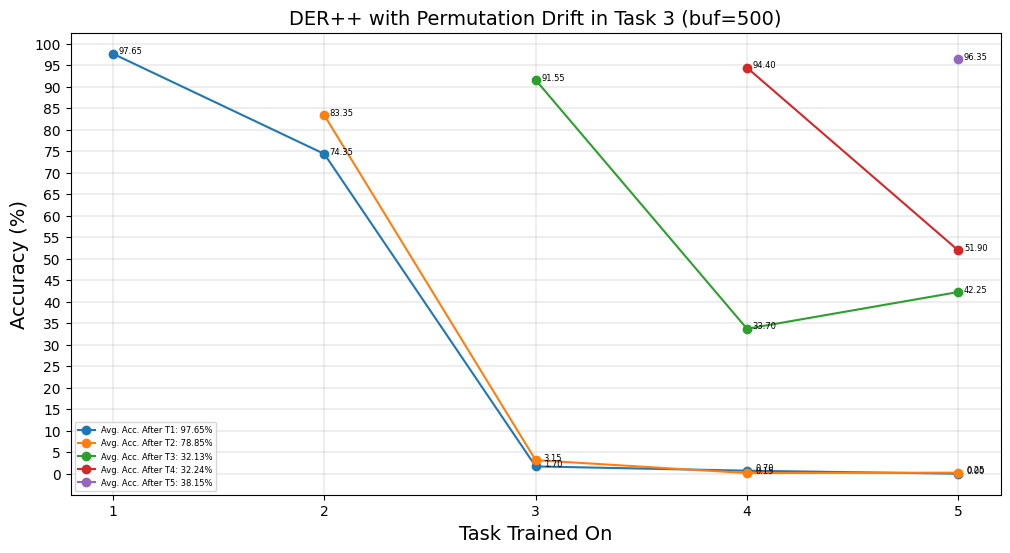

In [88]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-19-25-01-40-51-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-0.json"
)
# 35.85, 37.12, 38.15, 38.60, 39.44
# 37.832 ± 1.241924313313818
plot_results(
    derpp_500_accuracy_array_with_drift,
    title="DER++ with Permutation Drift in Task 3 (buf=500)",
)
average_forgetting(derpp_500_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [91]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-20-10-13-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 59.94, 61.09, 61.97, 62.82, 63.87
# # 61.938 ± 1.3581369592202395

3 files found
1: ./reimplementation-logs/02-19-25-01-28-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-05-04-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-03-15-39-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 64.30666666666667
Avg Forgetting: 36.375


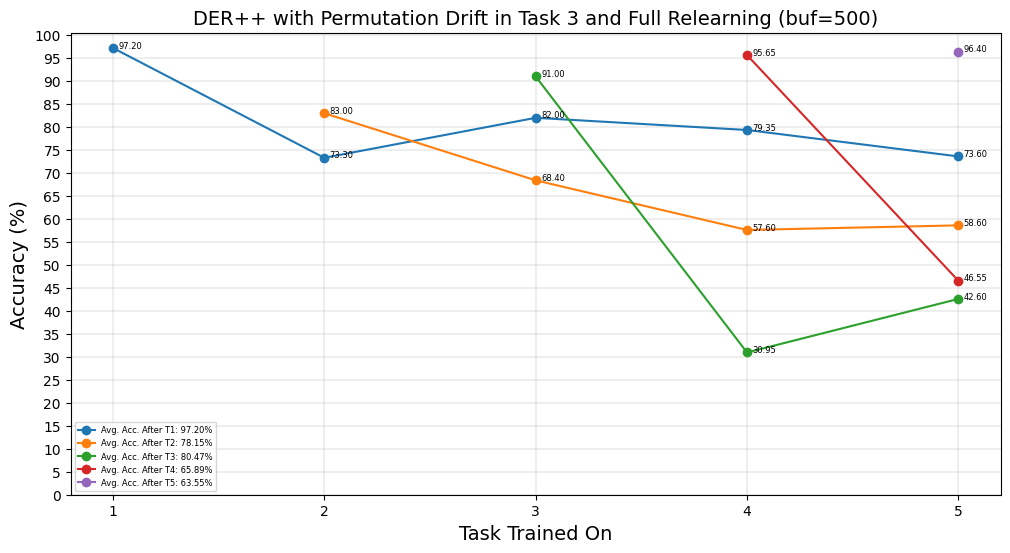

In [95]:
derpp_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-05-04-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)
# 63.32, 63.55, 66.05
plot_results(
    derpp_500_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Task 3 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [ ]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-20-25-04-17-47-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 50.92, 55.55, 55.69, 55.73, 56.73
# # 54.924 ± 2.045576691302478

3 files found
1: ./reimplementation-logs/02-19-25-06-23-34-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-09-03-29-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-07-43-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 55.13
Avg Forgetting: 45.175


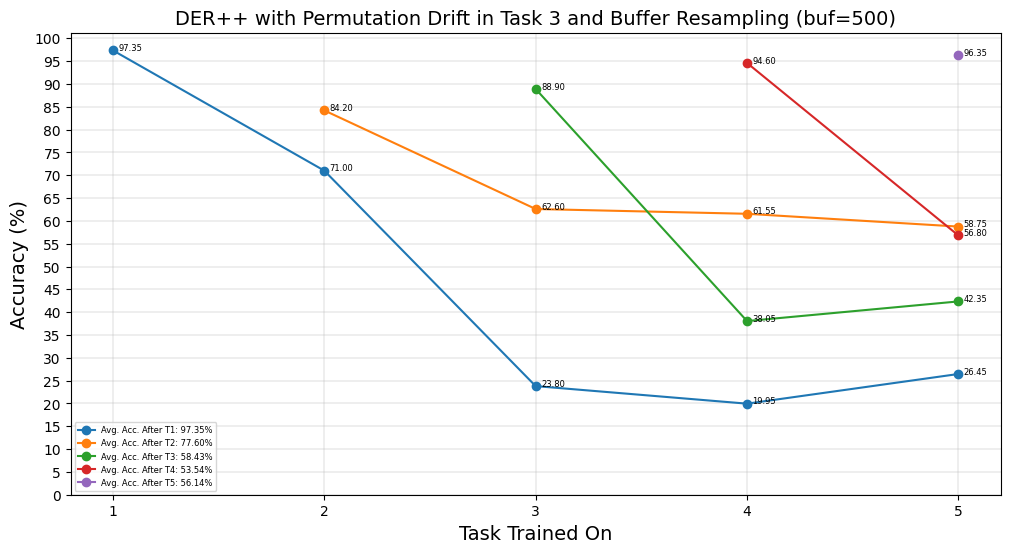

In [101]:
derpp_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-07-43-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)
# 52.87, 56.14, 56.38
plot_results(
    derpp_500_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

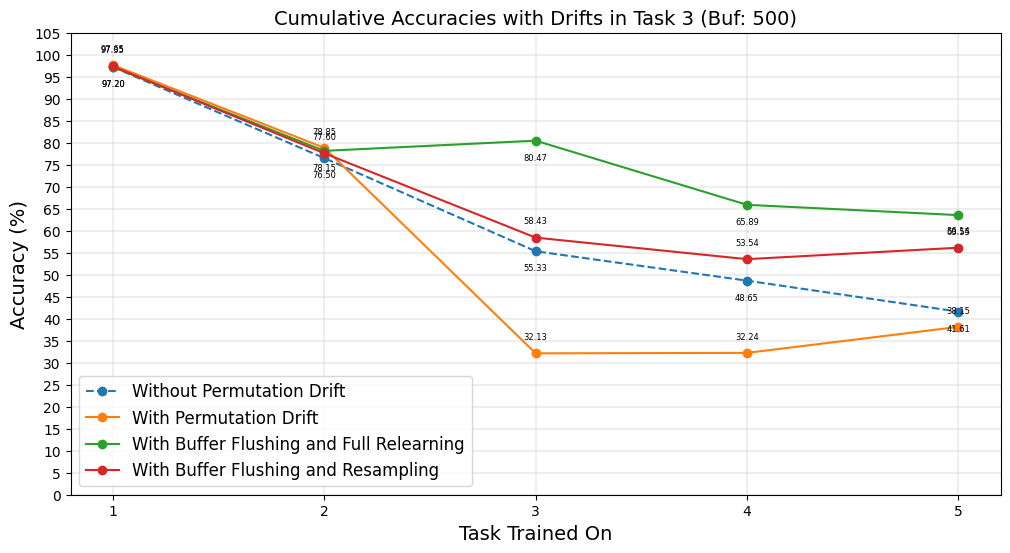

In [102]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

29.625000000000007

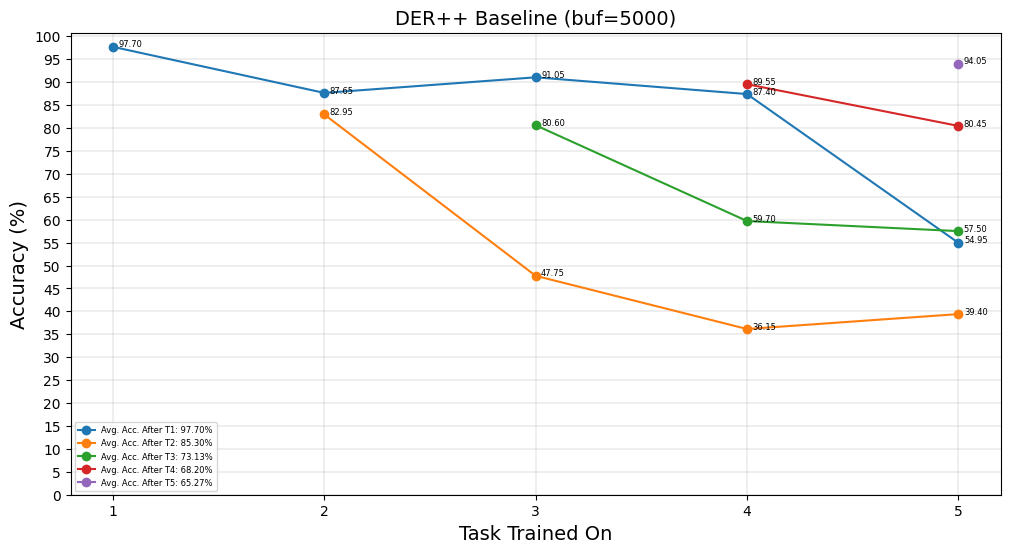

In [103]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-15-25-02-01-27-seq-cifar10-derpp-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 63.82, 64.41, 65.27, 66.30, 66.07
# 65.174 ± 0.9483585819720287
plot_results(
    derpp_5000_accuracy_array_without_drift,
    title="DER++ Baseline (buf=5000)",
)
average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

### Permutation Drift in Task 3

52.0625

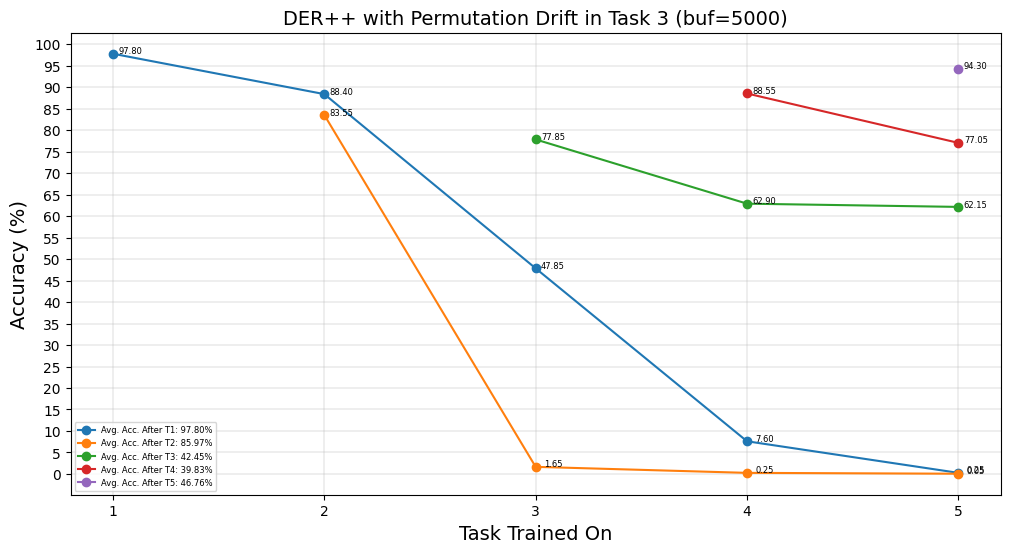

In [104]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-15-25-02-11-26-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 46.12, 46.27, 46.76, 46.81, 46.96
# 46.584 ± 0.32781702213277497
plot_results(
    derpp_5000_accuracy_array_with_drift,
    title="DER++ with Permutation Drift in Task 3 (buf=5000)",
)
average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

### Permutation Drift in Task 3 with Full Relearning

In [109]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-15-25-02-51-37-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 75.50, 75.54, 76.24, 76.31, 76.32
# # 75.982 ± 0.37843889863490215

3 files found
1: ./reimplementation-logs/02-19-25-03-20-44-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-01-32-19-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-05-10-59-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 75.76333333333332
Avg Forgetting: 18.962500000000002


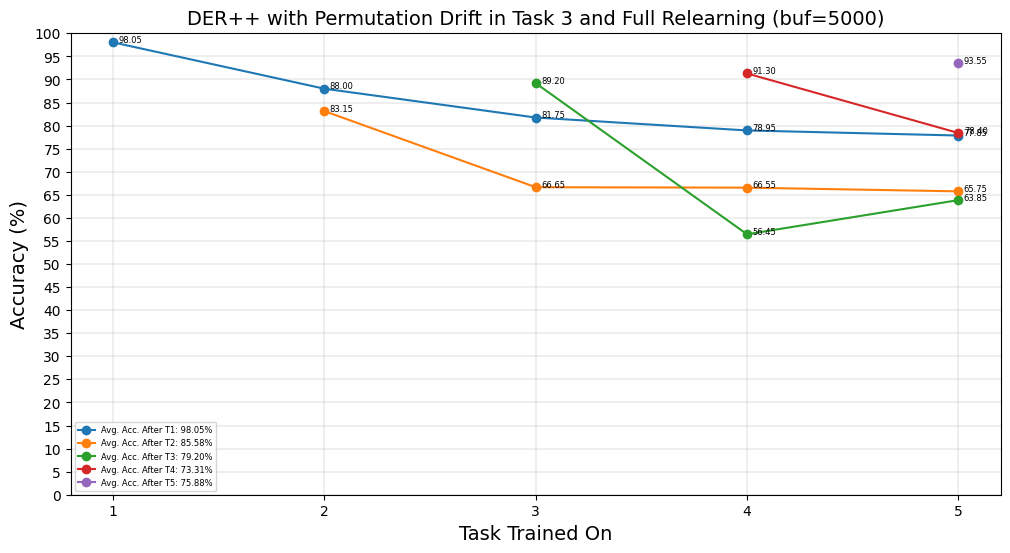

In [ ]:
derpp_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-05-10-59-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)
# 75.42, 75.88, 75.99
plot_results(
    derpp_5000_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Task 3 with Buffer Resampling

In [115]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-15-25-02-23-16-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 74.03, 74.04, 74.22, 74.25, 74.78
# # 74.26399999999998 ± 0.2732471408816561

3 files found
1: ./reimplementation-logs/02-19-25-09-09-22-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-07-49-34-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-06-30-51-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 70.64666666666666
Avg Forgetting: 25.262500000000003


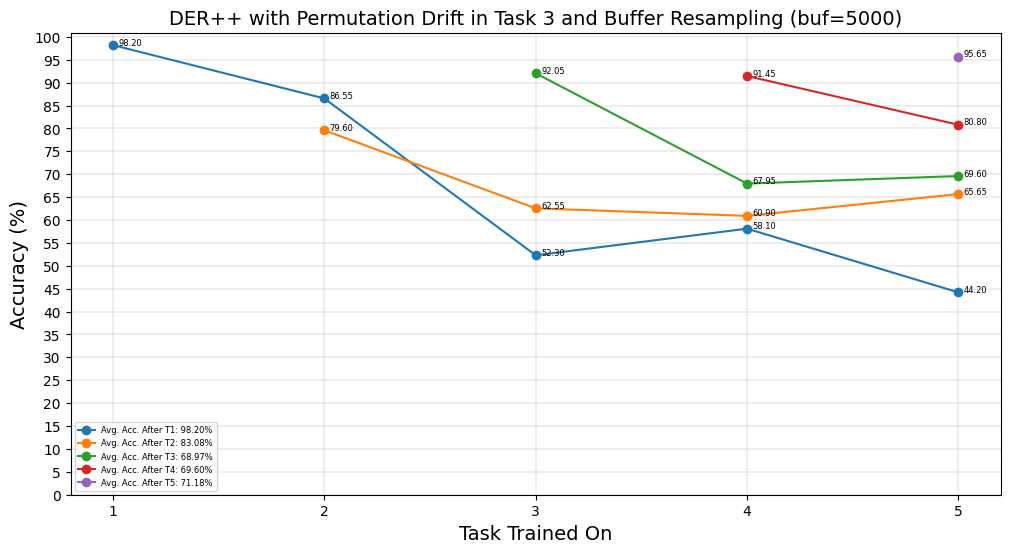

In [116]:
derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-09-09-22-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)
# 69.07, 71.18, 71.69
plot_results(
    derpp_5000_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

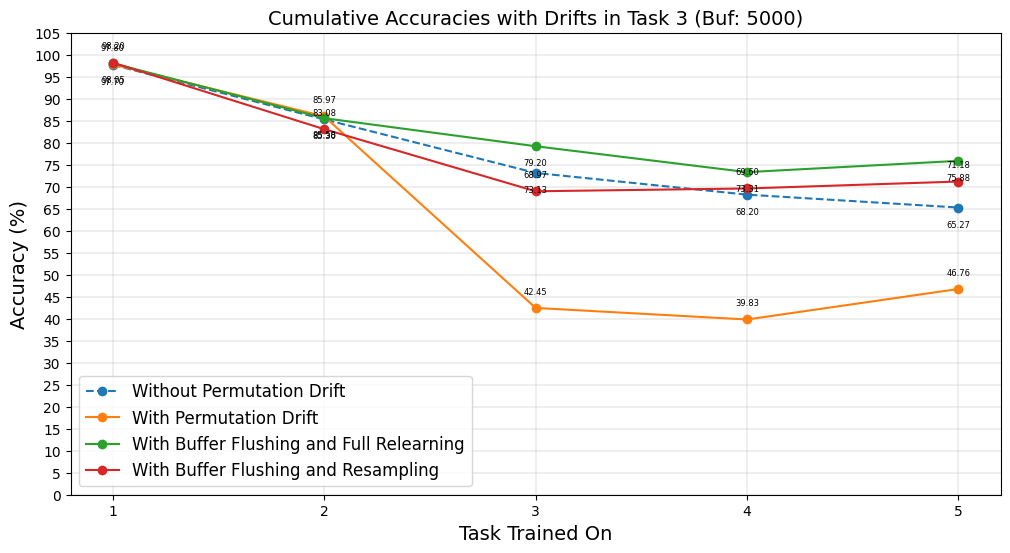

In [117]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

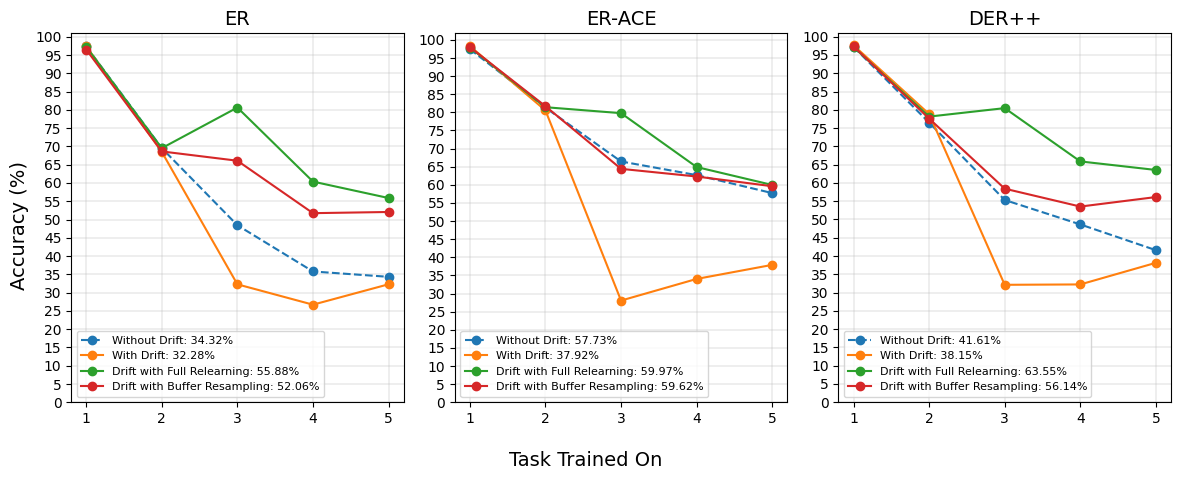

In [121]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_500_n_1.pdf",
)

## Buffer 5000

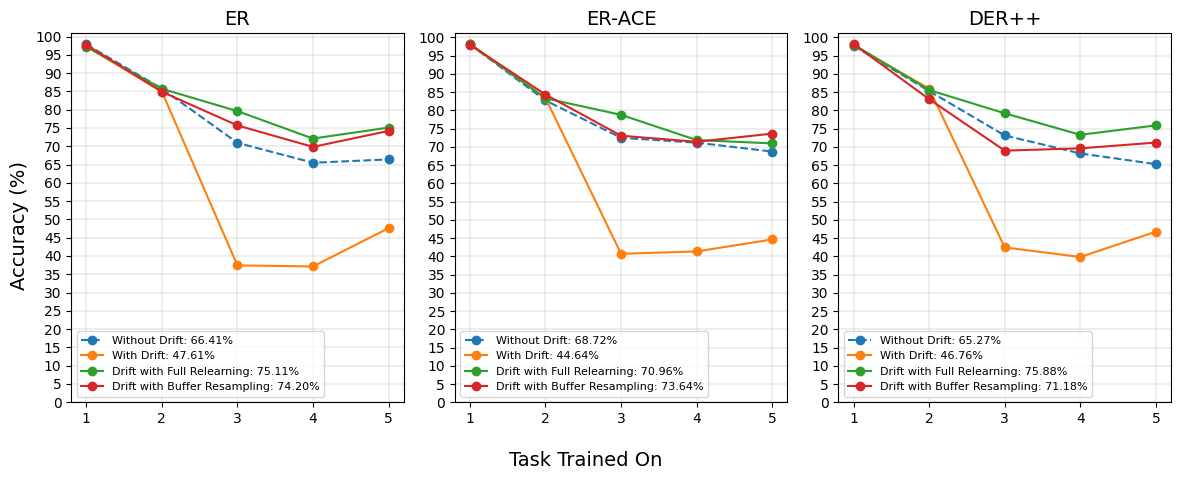

In [122]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_5000_n_1.pdf",
)